## 1. IMPORTANDO AS BIBLIOTECAS E OS DADOS DE TREINO E TESTE

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate


# Lendo os dados
caminho_dados = '../Dados_Treino_Teste'
X_treino = pd.read_csv(f'{caminho_dados}/X_treino.csv')
X_teste = pd.read_csv(f'{caminho_dados}/X_teste.csv')
y_treino = pd.read_csv(f'{caminho_dados}/y_treino.csv').squeeze()
y_teste = pd.read_csv(f'{caminho_dados}/y_teste.csv').squeeze()

## 2. TREINANDO O MODELO DE XGBOOST

       Verdadeiro  Predição
0             1.0         1
1             0.0         0
2             1.0         1
3             0.0         0
4             1.0         1
...           ...       ...
88162         1.0         1
88163         0.0         0
88164         0.0         0
88165         0.0         0
88166         0.0         0

[88167 rows x 2 columns]

Acurácia: 0.9998 — Proporção de acertos gerais do modelo.
Precisão: 1.0000 — Proporção de acertos entre as previsões positivas.
Recall: 0.9997 — Capacidade de encontrar todos os positivos reais.
F1-score: 0.9998 — Equilíbrio entre precisão e recall.


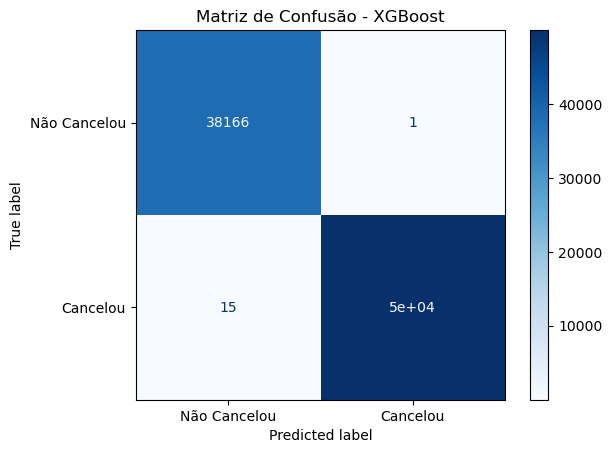

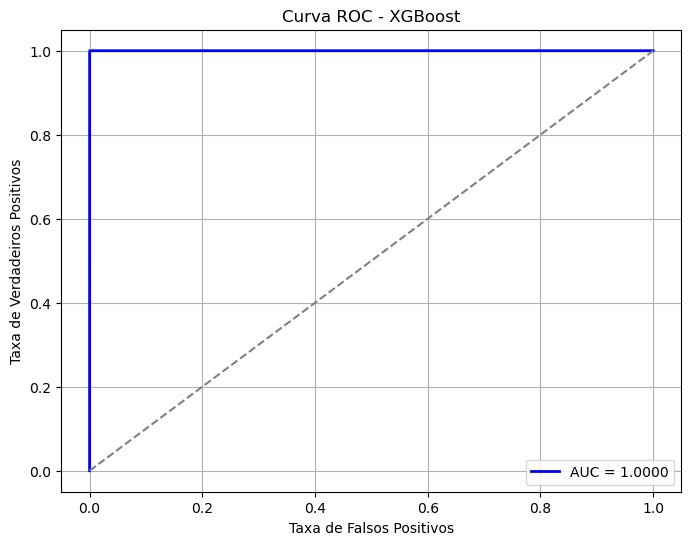

In [7]:
# Criando o modelo XGBoost
modelo_xgb = XGBClassifier(random_state=42)

# Treinando o modelo
modelo_xgb.fit(X_treino, y_treino)

# Fazendo previsões
y_pred = modelo_xgb.predict(X_teste)

# Comparando previsões com valores reais
df_resultado = pd.DataFrame({'Verdadeiro': y_teste, 'Predição': y_pred})
print(df_resultado)

# Avaliando o modelo
accuracy = accuracy_score(y_teste, y_pred)
precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f_score = f1_score(y_teste, y_pred)

print(f"\nAcurácia: {accuracy:.4f} — Proporção de acertos gerais do modelo.")
print(f"Precisão: {precision:.4f} — Proporção de acertos entre as previsões positivas.")
print(f"Recall: {recall:.4f} — Capacidade de encontrar todos os positivos reais.")
print(f"F1-score: {f_score:.4f} — Equilíbrio entre precisão e recall.")

# Matriz de Confusão
matriz = confusion_matrix(y_teste, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["Não Cancelou", "Cancelou"])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

# Curva ROC
y_probs = modelo_xgb.predict_proba(X_teste)[:, 1]  # Probabilidades da classe 1
fpr, tpr, thresholds = roc_curve(y_teste, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid()
plt.show()


## 3. VALIDAÇÃO CRUZADA

In [8]:
# Lendo os dados
caminho_dados = '../Dados_Treino_Teste'
X_treino = pd.read_csv(f'{caminho_dados}/X_treino.csv')
X_teste = pd.read_csv(f'{caminho_dados}/X_teste.csv')
y_treino = pd.read_csv(f'{caminho_dados}/y_treino.csv').squeeze()
y_teste = pd.read_csv(f'{caminho_dados}/y_teste.csv').squeeze()

# Unificando os dados
X = pd.concat([X_treino, X_teste], axis=0)
y = pd.concat([y_treino, y_teste], axis=0)

# Modelo XGBoost
modelo_xgb = XGBClassifier(eval_metric='logloss')

# Métricas
metricas = ['accuracy', 'precision', 'recall', 'f1']

# Validação cruzada
resultado = cross_validate(
    modelo_xgb,
    X,
    y,
    cv=5,
    scoring=metricas,
    return_train_score=False
)

# Criando o DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Métrica': [],
    'Média': [],
    'Desvio Padrão': []
})

for metrica in metricas:
    scores = resultado[f'test_{metrica}']
    media = np.mean(scores)
    desvio = np.std(scores)

    df_resultados = pd.concat([
        df_resultados,
        pd.DataFrame({'Métrica': [metrica],
                      'Média': [f'{media:.4f}'],
                      'Desvio Padrão': [f'{desvio:.4f}']})
    ], ignore_index=True)

# Exibindo os resultados
print(df_resultados)

     Métrica   Média Desvio Padrão
0   accuracy  0.9999        0.0001
1  precision  1.0000        0.0000
2     recall  0.9998        0.0001
3         f1  0.9999        0.0001


## 4. SALVANDO O MODELO XGBOOST

In [9]:
joblib.dump(modelo_xgb, 'modelo_xgboost.pkl')

['modelo_xgboost.pkl']